<a href="https://colab.research.google.com/github/tr-dev-bc/Modern_CV_Assignments/blob/main/steps_6_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 6

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt         # used to plot error later
# helps running in jupyter
%matplotlib inline

from torchvision import datasets, models

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"         # switch for gpu else cpu

# load and normalize the fmnist dataset
data_folder = '~/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [7]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/(255) # Normalizes images to [0,1]
        x = x.view(-1,1, 28,28)
        x = x.repeat(1, 3, 1, 1)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]  # unpack tuple into variables
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [8]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=64, shuffle=True)         # batch size is 64
    return trn_dl
    #The DataLoader class in PyTorch loads dataset data, cuts it into batches, shuffles it

# Adding RESNET18

In [9]:
def get_model():
    model = models.resnet18(pretrained=True)  # Load pre-trained ResNet18
    # freeze all but final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # change final layer outputing 10 classes
    model.fc = nn.Linear(model.fc.in_features, 10)

    model = model.to(device)  # moves to the GPU to make it faster
    loss_fn = nn.CrossEntropyLoss()  # required cross-entropy loss function
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-2)  # Optimize only the final layer
    return model, loss_fn, optimizer

# STEP 7: Train the fine-tuned ResNet18 model (from Question 6) on the Fashion-MNIST dataset for 5 epochs.

In [10]:
# loading up traiing data
train_loader = get_data()
model, loss_fn, optimizer = get_model()

# training loop with tracking of loss
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(x)
        loss = loss_fn(predictions, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

Epoch 1/5, Loss: 1.0919
Epoch 2/5, Loss: 0.8791
Epoch 3/5, Loss: 0.8463
Epoch 4/5, Loss: 0.8229
Epoch 5/5, Loss: 0.8163


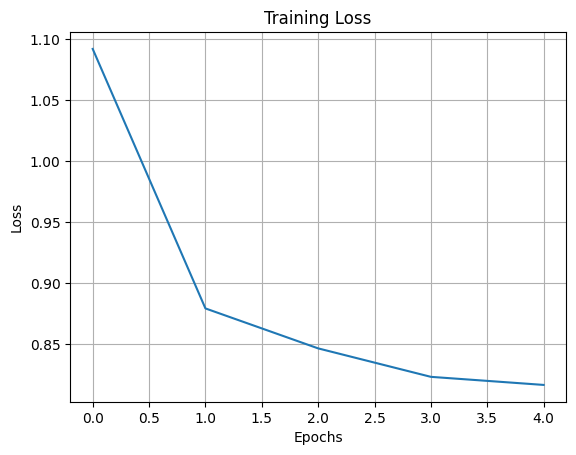

In [11]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()